In [72]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

class SVC_vis(SVC):
    
    def plot(self, data, labels, cmap='Accent', cols=[0,1], N=1000, ax=None, s=80):
        if not ax:
            fig, ax = plt.subplots(figsize=[10, 10])
        x = data.iloc[:, cols[0]]
        y = data.iloc[:, cols[1]]        
        x_range = np.linspace(x.min(), x.max(), N)
        y_range = np.linspace(y.min(), y.max(), N)
        x_grid, y_grid = np.meshgrid(x_range, y_range)
        z = self.predict(np.concatenate([x_grid.reshape(-1, 1), y_grid.reshape(-1, 1)],
                                       axis=1)) 
        
        mask = np.full(len(data), True)
        mask[self.support_] = False
        smask = np.logical_not(mask)
        ax.scatter(x[mask], y[mask], c=labels[mask], label='data', cmap=cmap)
        ax.contourf(x_grid, y_grid, z.reshape(x_grid.shape), alpha=0.3, cmap=cmap)
        ax.scatter(x[smask], y[smask], c=labels[smask], 
                   label='support vectors', cmap=cmap, marker='X', edgecolors='k', s=s)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'SVC with {self.kernel} kernel')
        ax.legend()

# Decision boundaries for blobs.csv

In [73]:
blobs = pd.read_csv('Data/blobs2.csv')
data_blobs = blobs.drop(columns='label')
labels_blobs = blobs['label']
blobs.head()

,x,y,label
0,0.543066,3.931424,0
1,2.563694,3.473101,0
2,0.665973,2.781159,0
3,3.552344,1.538645,1
4,1.397117,0.668682,1


### Linear kernel

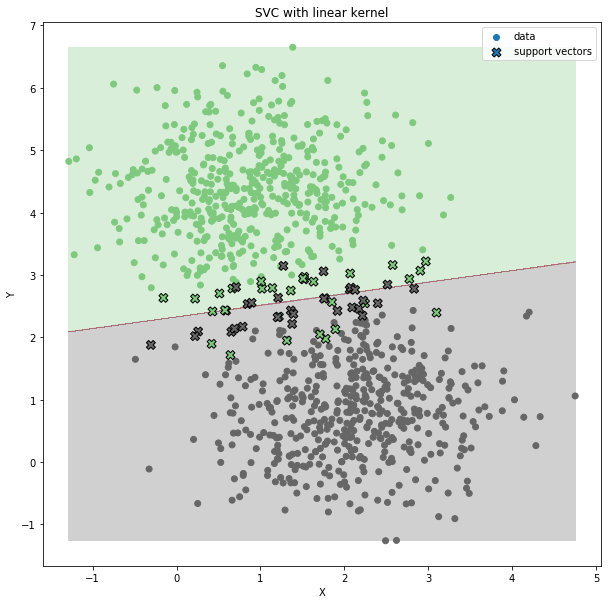

In [74]:
linear_svc = SVC_vis(kernel='linear')
linear_svc.fit(data_blobs, labels_blobs)
linear_svc.plot(data_blobs, labels_blobs)

### Polynomial kernel

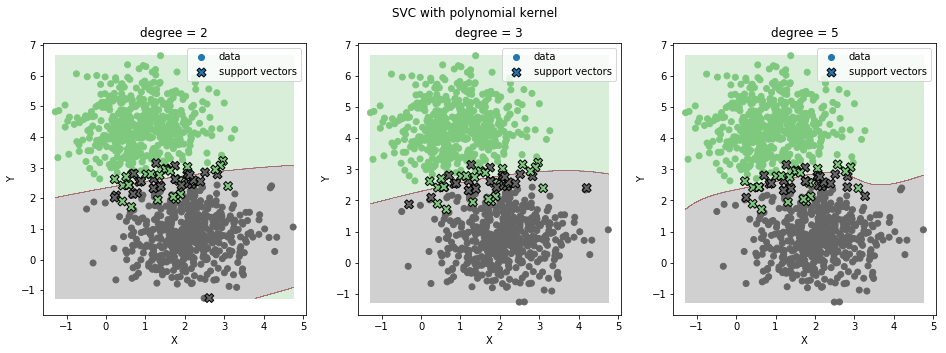

In [75]:
degrees = [2, 3, 5]
fig, axarr = plt.subplots(1, 3, figsize=[16, 5])
fig.suptitle('SVC with polynomial kernel')
for d, ax in zip(degrees, axarr):
    model = SVC_vis(kernel='poly', degree=d)
    model.fit(data_blobs, labels_blobs)
    model.plot(data_blobs, labels_blobs, ax=ax)
    ax.set_title(f'degree = {d}')

### RBF kernel

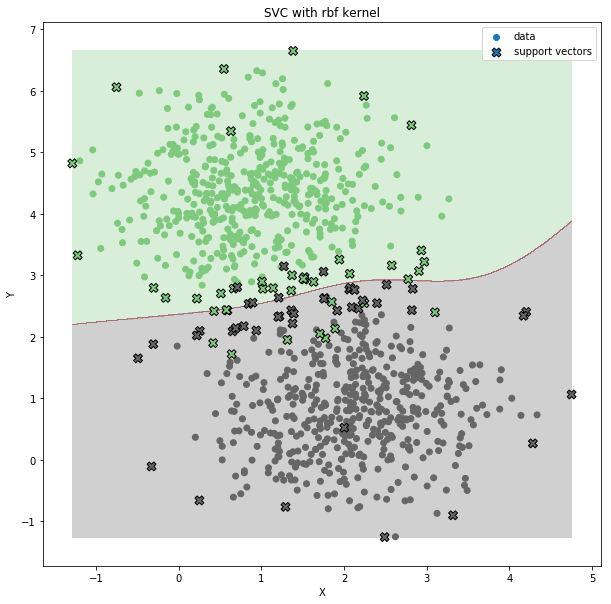

In [76]:
rbf_svc = SVC_vis(kernel='rbf')
rbf_svc.fit(data_blobs, labels_blobs)
rbf_svc.plot(data_blobs, labels_blobs)

# Comparing training time of SVC with Random Forest

In [37]:
from tqdm import tqdm_notebook
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
def assess(model, arr, labs, n_iter):
    t_time = []
    acc = []
    f1 = []
    for _ in tqdm_notebook(range(n_iter)):
        data = train_test_split(arr, labs, test_size=0.2, stratify=labs)
        start = time.clock()
        model.fit(data[0], data[2])
        t_time.append(time.clock()-start)
        acc.append(model.score(data[1], data[3]))
        f1.append(f1_score(data[3], model.predict(data[1])))
    print(type(model).__name__)
    print(f'Mean training time {round(np.mean(t_time), 3)} seconds')
    print(f'Mean accuracy = {round(np.mean(acc), 3)}')
    print(f'Mean f1 score= {round(np.mean(f1), 3)}')
    
scaler = StandardScaler()

### Cancer data set:

In [38]:
cancer = pd.read_csv('Data/cancer.csv')
cancer['label'], _ = pd.factorize(cancer['label'])
data_cancer = scaler.fit_transform(cancer.drop(columns='label'))
labels_cancer = cancer['label']
cancer.head()

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Data is split into train test at each itration inside the **assess** function.

In [39]:
rf_c = RandomForestClassifier(n_estimators=60, max_depth=4, min_samples_leaf=5, class_weight='balanced')
assess(rf_c, data_cancer, labels_cancer, n_iter=30)


RandomForestClassifier
Mean training time 0.076 seconds
Mean accuracy = 0.954
Mean f1 score= 0.963


In [40]:
svm_c = SVC(kernel='linear', class_weight='balanced')
assess(svm_c, data_cancer, labels_cancer, n_iter=30)


SVC
Mean training time 0.003 seconds
Mean accuracy = 0.969
Mean f1 score= 0.976


In [41]:
svm_c_l = LinearSVC(class_weight='balanced')
assess(svm_c_l, data_cancer, labels_cancer, n_iter=30)


LinearSVC
Mean training time 0.006 seconds
Mean accuracy = 0.968
Mean f1 score= 0.975


### Spam data set:

In [42]:
spam = pd.read_csv('Data/spam.csv')
data_spam = scaler.fit_transform(spam.drop(columns='label'))
labels_spam = spam['label']
print(spam.shape)
spam.head()

(4601, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [32]:
rf_s = RandomForestClassifier(n_estimators=10, class_weight='balanced')
assess(rf_s, data_spam, labels_spam, 20)


RandomForestClassifier
Mean training time 0.055 seconds
Mean accuracy = 0.944
Mean f1 score= 0.927


Linear from liblinear:

In [43]:
svm_s = LinearSVC(class_weight='balanced')
assess(svm_s, data_spam, labels_spam, 20)


LinearSVC
Mean training time 0.845 seconds
Mean accuracy = 0.924
Mean f1 score= 0.904


RBF classifier:

In [44]:
rbf_s = SVC(kernel='rbf', class_weight='balanced')
assess(rbf_s, data_spam, labels_spam, 20)


SVC
Mean training time 0.479 seconds
Mean accuracy = 0.932
Mean f1 score= 0.914


Polynomial:

In [48]:
poly_s = SVC(kernel='poly', degree=2, class_weight='balanced')
assess(rbf_s, data_spam, labels_spam, 20)


SVC
Mean training time 0.474 seconds
Mean accuracy = 0.933
Mean f1 score= 0.914


Linear from libsvm:

In [47]:
lin_s = SVC(kernel='linear', class_weight='balanced')
assess(lin_s, data_spam, labels_spam, 20)


SVC
Mean training time 0.529 seconds
Mean accuracy = 0.929
Mean f1 score= 0.91
